## Imports

In [47]:
import glob
import os
import cv2
import random
import torch
import torchvision

import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch import nn
from typing import Tuple, Any
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
import torchvision.models as models

In [48]:
os.environ["KMP_DUPLICATE_LIB_OK"] = (
    "True"  # A fix for some strange matplotlib error
)

In [71]:
MODELS_DIR = "models"
DATASET_DIR = "dataset"

## Set seed

In [50]:
seed = 44
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

## Load data

In [51]:
def load_data(dataset_folder_path: str) -> Tuple[pd.DataFrame, torch.tensor]:
    """
    Returns pd.Dataframe with targets and torch.tensor with photo data
    """
    df = None
    photos = []
    curr_photo_id = 0
    for csv_file in glob.glob(f"{dataset_folder_path}/*.csv"):
        folder_df = pd.read_csv(
            csv_file, header=None, names=["filename", "forward", "left"]
        )
        photo_folder_name = os.path.splitext(csv_file)[0]
        folder_df["folder_name"] = photo_folder_name
        photo_paths = glob.glob(f"{photo_folder_name}/*.jpg")
        for photo_path in photo_paths:
            photos.append(torchvision.io.read_image(photo_path))
        folder_df["photo_id"] = folder_df.index + curr_photo_id
        curr_photo_id += folder_df.index.max() + 1
        if df is None:
            df = folder_df
        else:
            df = pd.concat([df, folder_df], axis=0)
    df = df.set_index("photo_id")
    photos = torch.from_numpy(np.array(photos))
    return df, photos


df, photos = load_data(DATASET_DIR)
df

,filename,forward,left,folder_name
photo_id,,,,
0,8,0.000000,-0.78125,dataset/1652876206.2541456
1,9,0.000000,-1.00000,dataset/1652876206.2541456
2,10,1.000000,-1.00000,dataset/1652876206.2541456
3,11,1.000000,0.00000,dataset/1652876206.2541456
4,12,0.953125,0.00000,dataset/1652876206.2541456
...,...,...,...,...
7579,995,1.000000,-1.00000,dataset/1652876485.8123376
7580,996,1.000000,-1.00000,dataset/1652876485.8123376
7581,997,1.000000,-1.00000,dataset/1652876485.8123376


## Dataset

In [53]:
class JetbotDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        images: torch.tensor,
        transforms: list | None = None,
    ) -> None:
        """
        df: pd.DataFrame loaded by load_data()
        images: torch.tensor with image data loaded by load_data()
        transforms: a list of transforms to augment the data with
        """
        super().__init__()
        if transforms is None:
            transforms = []
        self.df = df
        self.images = images
        self.transforms = transforms

    def __len__(self) -> int:
        return self.df.shape[0]

    def __getitem__(self, index) -> Tuple[np.array, np.array]:
        sample = self.df.iloc[index]
        target = torch.tensor([sample.forward, sample.left], dtype=torch.float32)
        img = self.images[index].float()
        if len(self.transforms) > 0:
            random_transform = np.random.choice(self.transforms)
            img, target = random_transform(img, target)
            
        return img, target

In [54]:
def display_image(img: torch.tensor, target: torch.tensor = None):
    plt.imshow(img.numpy().astype(np.uint8).transpose((1, 2, 0)))
    if target is not None:
        plt.text(
            0,
            -10,
            f'Target: [{",".join([str(i) for i in target])}]',
            fontsize="x-large",
        )

## Transforms

In [55]:
class RandomJetbotHorizontalFlip(torch.nn.Module):
    def __init__(self, p: float = 0.5) -> None:
        super().__init__()
        self.p = p

    def forward(self, *inputs: Any) -> Any:
        img, target = inputs
        if np.random.random() >= self.p:  # Flip
            img = torchvision.transforms.functional.hflip(img)
            target[1] *= -1  # Flip 'left' component
        return img, target


# Vertical flip doesn't make sense in our problem

train_transforms = [RandomJetbotHorizontalFlip()]  # Feel free to add more
test_transforms = []  # Test on original examples

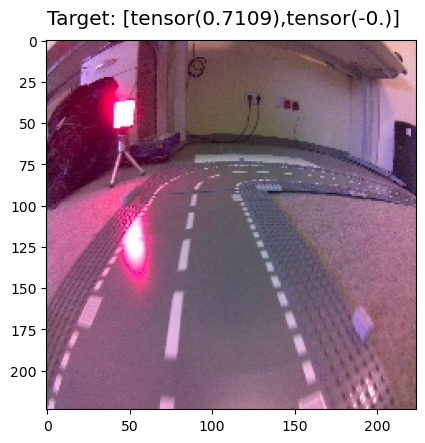

In [56]:
dataset = JetbotDataset(df, photos, train_transforms)
img, target = dataset[400]
display_image(img, target)

## Train-test-validation split

In [65]:
train_size = 0.7
val_size = 0.15
test_size = 1 - (train_size + val_size)
batch_size = 64

data_indices = np.random.permutation(np.arange(df.shape[0]))

train_end_index = int(len(data_indices) * train_size)
val_end_index = train_end_index + int(len(data_indices) * val_size)

train_dataloader = DataLoader(
    JetbotDataset(
        df.iloc[data_indices[:train_end_index]],
        photos[data_indices[:train_end_index]],
        transforms=train_transforms
    ),
    batch_size=batch_size,
)

val_dataloader = DataLoader(
    JetbotDataset(
        df.iloc[data_indices[train_end_index:val_end_index]],
        photos[data_indices[train_end_index:val_end_index]],
    ),
    batch_size=batch_size,
)

test_dataloader = DataLoader(
    JetbotDataset(
        df.iloc[data_indices[val_end_index:]],
        photos[data_indices[val_end_index:]],
    ),
    batch_size=batch_size,
)

## Training / Evaluation functions.

In [74]:
def train_model(
    model: nn.Module,
    epochs: int,
    trainloader: DataLoader,
    validloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_func: callable,
    model_save_path: str,
    force_cuda: bool = False,
):
    """
    Taken from https://www.geeksforgeeks.org/training-neural-networks-with-validation-using-pytorch/,
    feel free to change it
    """
    if force_cuda and torch.cuda.is_available():
        model.cuda()

    min_valid_loss = np.inf
    for e in range(epochs):
        train_loss = 0.0
        model.train()  # Optional when not using Model Specific layer
        for data, labels in tqdm(trainloader):
            if force_cuda and torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()

            optimizer.zero_grad()
            target = model(data)
            loss = loss_func(target, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        valid_loss = 0.0
        model.eval()  # Optional when not using Model Specific layer
        for data, labels in tqdm(validloader):
            if torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()

            target = model(data)
            loss = loss_func(target, labels)
            valid_loss = loss.item() * data.size(0)

        print(
            f"Epoch {e+1} \t\t Training Loss: {train_loss / len(trainloader)} \t\t Validation Loss: {valid_loss / len(validloader)}"
        )
        
        if min_valid_loss > valid_loss:
            print(
                f"Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model"
            )
            min_valid_loss = valid_loss
            # Saving State Dict
            torch.save(model.state_dict(), model_save_path)

In [67]:
def evaluate_model(
    model: nn.Module,
    dataloader: DataLoader,
    loss_func: callable,
    device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
):
    model.to(device)
    model.eval()

    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)

            outputs = model(data)
            loss = loss_func(outputs, labels)
            
            total_loss += loss.item() * data.size(0)
            total_samples += data.size(0)

    avg_loss = total_loss / total_samples
    return avg_loss

## Model 1: Classical Convolution

In [68]:
class ClassicConv(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(10, 50, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(50, 100, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
        )
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))
        self.fully_connected = nn.Sequential(
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.ReLU(),
            nn.Linear(10, 2),
            nn.Tanh(),
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.global_pool(x)
        x = x.flatten(1, -1)
        x = self.fully_connected(x)
        return x

In [69]:
conv_model = ClassicConv()
optimizer = torch.optim.Adam(conv_model.parameters(), lr=0.001)
loss = nn.MSELoss()
print(conv_model)
print(f"Total number of parameters = {sum(p.numel() for p in conv_model.parameters())}")

ClassicConv(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 50, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (global_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (fully_connected): Sequential(
    (0): Linear(in_features=100, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=2, bias=True)
    (5): Tanh()
  )
)
Total number of p

In [70]:
train_model(
    conv_model,
    epochs=15,
    trainloader=train_dataloader,
    validloader=val_dataloader,
    optimizer=optimizer,
    loss_func=loss,
    model_save_path=f'{MODELS_DIR}/Model1.pth',
    force_cuda=True
)

  0%|          | 0/83 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:00<00:00, 18.93it/s]


Epoch 1 		 Training Loss: 0.258363090186234 		 Validation Loss: 0.8129446026351717
Validation Loss Decreased(inf--->14.633003) 	 Saving The Model


100%|██████████| 18/18 [00:01<00:00, 13.57it/s]


Epoch 2 		 Training Loss: 0.2416857321219272 		 Validation Loss: 0.8142591284381019


100%|██████████| 18/18 [00:01<00:00, 10.92it/s]


Epoch 3 		 Training Loss: 0.2413023022643055 		 Validation Loss: 0.8243280731969409


100%|██████████| 18/18 [00:01<00:00, 14.08it/s]


Epoch 4 		 Training Loss: 0.23378759838012328 		 Validation Loss: 0.797857532898585
Validation Loss Decreased(14.633003--->14.361436) 	 Saving The Model


100%|██████████| 18/18 [00:01<00:00, 11.53it/s]


Epoch 5 		 Training Loss: 0.23208867390471768 		 Validation Loss: 0.791933364338345
Validation Loss Decreased(14.361436--->14.254801) 	 Saving The Model


100%|██████████| 18/18 [00:00<00:00, 18.68it/s]


Epoch 6 		 Training Loss: 0.22945379762046308 		 Validation Loss: 0.7961734665764703


100%|██████████| 18/18 [00:01<00:00, 17.01it/s]


Epoch 7 		 Training Loss: 0.2298077350280371 		 Validation Loss: 0.7896822906202741
Validation Loss Decreased(14.254801--->14.214281) 	 Saving The Model


100%|██████████| 18/18 [00:00<00:00, 19.28it/s]


Epoch 8 		 Training Loss: 0.22898945320083433 		 Validation Loss: 0.7745613091521792
Validation Loss Decreased(14.214281--->13.942104) 	 Saving The Model


100%|██████████| 18/18 [00:00<00:00, 18.98it/s]


Epoch 9 		 Training Loss: 0.2284250753112586 		 Validation Loss: 0.8327726622422537


100%|██████████| 18/18 [00:01<00:00, 17.51it/s]


Epoch 10 		 Training Loss: 0.22663365160844412 		 Validation Loss: 0.8078984071811041


100%|██████████| 18/18 [00:01<00:00, 14.83it/s]


Epoch 11 		 Training Loss: 0.2255509574729276 		 Validation Loss: 0.8145517590973113


100%|██████████| 18/18 [00:00<00:00, 19.17it/s]


Epoch 12 		 Training Loss: 0.22201799035790454 		 Validation Loss: 0.8253840423292584


100%|██████████| 18/18 [00:00<00:00, 18.92it/s]


Epoch 13 		 Training Loss: 0.22390035656561336 		 Validation Loss: 0.801966937051879


100%|██████████| 18/18 [00:01<00:00, 14.87it/s]


Epoch 14 		 Training Loss: 0.21784499628716206 		 Validation Loss: 0.8047840446233749


100%|██████████| 18/18 [00:00<00:00, 18.73it/s]

Epoch 15 		 Training Loss: 0.21579600044761796 		 Validation Loss: 0.8172070152229733


In [18]:
conv_model.load_state_dict(torch.load('Model1.pth'))

avg_loss = evaluate_model(conv_model, test_dataloader, nn.MSELoss())
print(f'Test Loss: {avg_loss:.4f}')

Test Loss: 0.1190


## Model 2: deeper conv model

In [75]:
class DeepConv(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
        )
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
        )
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))
        self.fully_connected = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
            nn.Tanh(),
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.global_pool(x)
        x = x.flatten(1, -1)
        x = self.fully_connected(x)
        return x

In [76]:
deep_conv_model = DeepConv()
optimizer = torch.optim.Adam(deep_conv_model.parameters())
loss = nn.MSELoss()
print(deep_conv_model)
print(f"Total number of parameters = {sum(p.numel() for p in deep_conv_model.parameters())}")

DeepConv(
  (conv_block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (global_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (fully_connected): Sequential(
    (0): Linear(in_features=128, out_f

In [77]:
train_model(
    deep_conv_model,
    epochs=15,
    trainloader=train_dataloader,
    validloader=val_dataloader,
    optimizer=optimizer,
    loss_func=loss,
    model_save_path=f'{MODELS_DIR}/Model2.pth',
    force_cuda=True
)

  0%|          | 0/83 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:01<00:00, 17.97it/s]


Epoch 1 		 Training Loss: 0.2544776483113507 		 Validation Loss: 0.7935241328345405
Validation Loss Decreased(inf--->14.283434) 	 Saving The Model


100%|██████████| 18/18 [00:00<00:00, 20.12it/s]


Epoch 2 		 Training Loss: 0.23429318185312203 		 Validation Loss: 0.7872060851918327
Validation Loss Decreased(14.283434--->14.169710) 	 Saving The Model


100%|██████████| 18/18 [00:00<00:00, 20.78it/s]


Epoch 3 		 Training Loss: 0.23223830364554762 		 Validation Loss: 0.7849670996268591
Validation Loss Decreased(14.169710--->14.129408) 	 Saving The Model


100%|██████████| 18/18 [00:00<00:00, 20.59it/s]


Epoch 4 		 Training Loss: 0.23403562659240632 		 Validation Loss: 0.7928133656581243


100%|██████████| 18/18 [00:00<00:00, 19.79it/s]


Epoch 5 		 Training Loss: 0.2326428954859814 		 Validation Loss: 0.7981904033157561


100%|██████████| 18/18 [00:01<00:00, 10.76it/s]


Epoch 6 		 Training Loss: 0.2314891138349671 		 Validation Loss: 0.7895946717924542


100%|██████████| 18/18 [00:00<00:00, 19.45it/s]


Epoch 7 		 Training Loss: 0.2305691911872611 		 Validation Loss: 0.7932826942867703


100%|██████████| 18/18 [00:00<00:00, 20.00it/s]


Epoch 8 		 Training Loss: 0.23008505066475235 		 Validation Loss: 0.7981377508905199


100%|██████████| 18/18 [00:00<00:00, 20.85it/s]


Epoch 9 		 Training Loss: 0.2302438024296818 		 Validation Loss: 0.8033758964803484


100%|██████████| 18/18 [00:00<00:00, 19.80it/s]


Epoch 10 		 Training Loss: 0.23076053286891385 		 Validation Loss: 0.7834568106465869
Validation Loss Decreased(14.129408--->14.102223) 	 Saving The Model


100%|██████████| 18/18 [00:00<00:00, 20.76it/s]


Epoch 11 		 Training Loss: 0.2284934518926115 		 Validation Loss: 0.8140387833118439


100%|██████████| 18/18 [00:00<00:00, 20.91it/s]


Epoch 12 		 Training Loss: 0.22887827491903878 		 Validation Loss: 0.7899254328674741


100%|██████████| 18/18 [00:00<00:00, 19.79it/s]


Epoch 13 		 Training Loss: 0.2276418966701232 		 Validation Loss: 0.7812021672725677
Validation Loss Decreased(14.102223--->14.061639) 	 Saving The Model


100%|██████████| 18/18 [00:00<00:00, 20.02it/s]


Epoch 14 		 Training Loss: 0.22430937351232552 		 Validation Loss: 0.7772710025310516
Validation Loss Decreased(14.061639--->13.990878) 	 Saving The Model


100%|██████████| 18/18 [00:01<00:00, 17.92it/s]

Epoch 15 		 Training Loss: 0.22578583998852467 		 Validation Loss: 0.7816792031129202


In [22]:
deep_conv_model.load_state_dict(torch.load('Model2.pth'))

avg_loss = evaluate_model(deep_conv_model, test_dataloader, nn.MSELoss())
print(f'Test Loss: {avg_loss:.4f}')

Test Loss: 0.1027


## Model 3: Resnet alike

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.skip:
            identity = self.skip(identity)

        out += identity
        out = self.relu(out)
        return out

class ResNetLike(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
        )
        self.res_block1 = ResidualBlock(16, 32)
        self.res_block2 = ResidualBlock(32, 64)
        self.res_block3 = ResidualBlock(64, 128)
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))
        self.fully_connected = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
            nn.Tanh(),
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block1(x)
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        x = self.global_pool(x)
        x = x.flatten(1, -1)
        x = self.fully_connected(x)
        return x

In [24]:
resnetlike_model = ResNetLike()
optimizer = torch.optim.Adam(resnetlike_model.parameters())
loss = nn.MSELoss()
print(resnetlike_model)
print(f"Total number of parameters = {sum(p.numel() for p in resnetlike_model.parameters())}")

ResNetLike(
  (conv_block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (res_block1): ResidualBlock(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (skip): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (res_block2): ResidualBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [25]:
train_model(
    resnetlike_model,
    epochs=15,
    trainloader=train_dataloader,
    validloader=val_dataloader,
    optimizer=optimizer,
    loss_func=loss,
    model_save_path=f'{MODELS_DIR}/Model3.pth',
    force_cuda=True
)

100%|██████████| 18/18 [00:03<00:00,  5.55it/s]


Epoch 1 		 Training Loss: 0.24507014686802783 		 Validation Loss: 0.6421665830744637
Validation Loss Decreased(inf--->11.558998) 	 Saving The Model


100%|██████████| 18/18 [00:02<00:00,  6.52it/s]


Epoch 2 		 Training Loss: 0.19646584942757364 		 Validation Loss: 0.4473227138320605
Validation Loss Decreased(11.558998--->8.051809) 	 Saving The Model


100%|██████████| 18/18 [00:02<00:00,  6.59it/s]


Epoch 3 		 Training Loss: 0.1350345976920013 		 Validation Loss: 0.34822115467654335
Validation Loss Decreased(8.051809--->6.267981) 	 Saving The Model


100%|██████████| 18/18 [00:02<00:00,  6.71it/s]


Epoch 4 		 Training Loss: 0.11377634099089956 		 Validation Loss: 0.34038324488533866
Validation Loss Decreased(6.267981--->6.126898) 	 Saving The Model


100%|██████████| 18/18 [00:02<00:00,  6.64it/s]


Epoch 5 		 Training Loss: 0.10633038065160613 		 Validation Loss: 0.2813343409862783
Validation Loss Decreased(6.126898--->5.064018) 	 Saving The Model


100%|██████████| 18/18 [00:02<00:00,  6.60it/s]


Epoch 6 		 Training Loss: 0.10066938687519855 		 Validation Loss: 0.2705252605179946
Validation Loss Decreased(5.064018--->4.869455) 	 Saving The Model


100%|██████████| 18/18 [00:02<00:00,  6.59it/s]


Epoch 7 		 Training Loss: 0.09636040373020861 		 Validation Loss: 0.3701676022675302


100%|██████████| 18/18 [00:02<00:00,  6.65it/s]


Epoch 8 		 Training Loss: 0.08751585859670696 		 Validation Loss: 0.35116397092739743


100%|██████████| 18/18 [00:02<00:00,  6.67it/s]


Epoch 9 		 Training Loss: 0.08129758921911917 		 Validation Loss: 0.4232813244064649


100%|██████████| 18/18 [00:02<00:00,  6.61it/s]


Epoch 10 		 Training Loss: 0.07589217854371991 		 Validation Loss: 0.5590106364753511


100%|██████████| 18/18 [00:02<00:00,  6.66it/s]


Epoch 11 		 Training Loss: 0.08172755661499069 		 Validation Loss: 0.32597382159696686


100%|██████████| 18/18 [00:02<00:00,  6.63it/s]


Epoch 12 		 Training Loss: 0.07802554668791323 		 Validation Loss: 0.3521321184105343


100%|██████████| 18/18 [00:02<00:00,  6.66it/s]


Epoch 13 		 Training Loss: 0.06590507709118257 		 Validation Loss: 0.30421346260441673


100%|██████████| 18/18 [00:02<00:00,  6.51it/s]


Epoch 14 		 Training Loss: 0.061720463234078454 		 Validation Loss: 0.2628064677119255
Validation Loss Decreased(4.869455--->4.730516) 	 Saving The Model


100%|██████████| 18/18 [00:02<00:00,  6.62it/s]

Epoch 15 		 Training Loss: 0.07037991141698446 		 Validation Loss: 0.26193652633163667
Validation Loss Decreased(4.730516--->4.714857) 	 Saving The Model


In [26]:
resnetlike_model.load_state_dict(torch.load('Model3.pth'))

avg_loss = evaluate_model(resnetlike_model, test_dataloader, nn.MSELoss())
print(f'Test Loss: {avg_loss:.4f}')

Test Loss: 0.1143


## Exporting to ONNX

In [41]:
import onnxruntime as ort

input_t = torch.randint(0, 256, (1, 3, 224, 224), dtype=torch.float32)

def export_to_onnx(model_cls: type[nn.Module], pth_file: str, onnx_file: str):
    model = model_cls()
    model.load_state_dict(torch.load(pth_file))
    onnx_program = torch.onnx.export(model, input_t, onnx_file, opset_version=11)

def run_onnx_on_dummy_input(onnx_file: str):
    ort_sess = ort.InferenceSession(onnx_file)
    outputs = ort_sess.run(None, {'input.1': input_t.numpy()})

    # Print Result
    # predicted, actual = classes[outputs[0][0].argmax(0)], classes[y]
    # print(f'Predicted: "{predicted}", Actual: "{actual}"')
    return outputs

In [36]:
models_cls = [ClassicConv, DeepConv, ResNetLike]
pth_files = [f"Model{i}.pth" for i in (1,2,3)]
onnx_files = [f"Model{i}.onnx" for i in (1,2,3)]

for model_cls, pth_file, onnx_file in zip(models_cls, pth_files, onnx_files):
    export_to_onnx(model_cls, pth_file, onnx_file)

In [46]:
run_onnx_on_dummy_input(onnx_files[1])

[array([[0.8325899 , 0.00761106]], dtype=float32)]